# **Preprocessing**

### **Analizing Data**

Pada tahapan ini kita akan menyiapkan library yang dibutuhkan dan melakukan import class dan juga kita akan menganalisa dari karakter datanya

In [140]:
# importing library
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud.wordcloud import WordCloud
import re
import string
import numpy as np
import pandas as pd

In [141]:
# import dataset
df = pd.read_csv("chatgpt_reviews.csv")

# membaca data
df.head()

,date,title,review,rating
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4


lalu kita akan melihat dalam setiap class ada berapa jumlah dataset nya

In [142]:
# melihat banyak data setiap class
df.rating.value_counts()

rating
5    1134
1     495
4     304
3     220
2     139
Name: count, dtype: int64

dari di atas kita dapat melihat bahwa ada pada datset kita, class yang mempunyai banyak data yang paling banyak adalah data dengan rating 5 dan rating dengan 1. dengan hal ini yang sangat mencerminkan negatif itu 1 dan yang sangat mencerminkan positif adalah 5. Karena 2-4 masih sangat kualitatif sekali.


### **Feature Selection**

Dalam tahapan ini kita akan melakukan seleksi lagi untuk fiturnya. Jadi untuk fitur yang tidak dibutuhkan, akan dihilangkan. Dalam kasus text mining kita hanya perlu document dan labelnya. fitur reviews akan menjadi document dan rating yang akan  menjadi label.

In [143]:
# untuk menghilangkan fitur
df.drop(columns=["date", "title"], inplace=True)

df.head()

,review,rating
0,Up to this point I’ve mostly been using ChatGP...,4
1,I’ve been a user since it’s initial roll out a...,4
2,This app would almost be perfect if it wasn’t ...,4
3,"I recently downloaded the app and overall, it'...",4
4,I appreciate the devs implementing Siri suppor...,4


### **Duplicated Data**

Dalam tahapan ini kita akan melihat apakah ada data yang terduplikasi atau tidak. Tujuannya adalah untuk menghilangkan data yang dapat mengganggu dalam proses modeling nya. Model akan lebih cenderung belajar yang sama dan menjadi menghafal data yang diulang ulang terus sehingga akan sulit menebak data baru. Inilah overfitting.

In [144]:
# untuk melihat data yang terduplikasi
df[df.duplicated()]

,review,rating
1351,Thanks,5
1508,Please,5
1783,Love it,5
1800,First,5
1801,First,5
1802,First,5
1827,Why?,1
1853,Very good,5
1866,Pretty good,5
1869,Great,5


dari tampilan di atas, kita dapat melihat bahwa ada data yang terduplikasi. Maka kita perlu untuk menghapusnya

In [145]:
# untuk menghapus data duplikat
df.drop_duplicates(inplace=True)

df.head()

,review,rating
0,Up to this point I’ve mostly been using ChatGP...,4
1,I’ve been a user since it’s initial roll out a...,4
2,This app would almost be perfect if it wasn’t ...,4
3,"I recently downloaded the app and overall, it'...",4
4,I appreciate the devs implementing Siri suppor...,4


### **Missing Value**

Pada tahapan ini kita akan mencari apakah ada data yang hilang atau tidak. Dalam kasus text mining jika data hilang adalah review maka kita bisa menghapus item tersebut karena jika review nya hilang tidak dapat digantikan dengan apa apa karena datanya selalu unik.

In [146]:
# untuk menghitung data kosong jenis Nan
df.isna().sum()

review    0
rating    0
dtype: int64

In [147]:
# untuk menghitung data kosong jenis null
df.isnull().sum()

review    0
rating    0
dtype: int64

In [148]:
# nilai unik rating
df.rating.unique()

array([4, 1, 3, 5, 2], dtype=int64)

melihat dari analisa di atas, kita tidak menemukan data yang kosong. Maka kita bisa mengabaikannya

In [149]:
df = pd.concat([df[df.rating == 1], df[df.rating == 5].iloc[:500]]).sample(frac=1, random_state=123)

df

,review,rating
1239,Accidentally entered my birthday as today’s da...,1
118,This app is quite quick for an AI software tha...,5
918,This is very helpful to me.,5
898,"Great service, glad it finally has its own off...",5
1252,Compatability not for voice over because ther...,1
...,...,...
917,"Truly the best ChatGPT experience, with speech...",5
1647,You lost me at wanting my phone number.,1
1845,Unusable on iPad Pro currently.,1
1784,Hello! I’ll be the first to review 🙂 the app i...,1


### **Train Test Split**

Pada tahapan ini kita akan melakukan pemisahan antara data tes dan data trainnya. Tujuannya adalah untuk dapat menggunakan data test yang akan digunakan untuk mengetahui performa model. Dan kami memutuskan menempatkan train test split pada tahapan ini bertujuan agar bisa dilakukan pengetesan pada kasus real (benar benar bentuk text)

In [150]:
# mengembalikan x, y yang sudah di split 
def Train_Test_Split(x, y, random_seed=None, test_size=0.8):
    # banyaknya data
    n = len(x)

    # jika ada data yang pasti ke acakannya
    if random_seed:
        np.random.seed(random_seed)

    # banyaknya data test
    test_size = int(test_size*n)

    # matriks random untuk menentukan index data train dan data test
    indices = np.random.permutation(n)

    # menentukan index
    train_indices, test_indices = indices[test_size:], indices[:test_size]

    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# menentukan x dan y nya
x = df["review"]
y = df["rating"]


# mengimplementasikan pada data
X_train, X_test, y_train, y_test = Train_Test_Split(x, y, random_seed=42, test_size=0.8)

X_train

1141    Anyone concerned with privacy should delete th...
225     I think you can add if the ai can finish lyric...
913     This app is next level ! I love that I can now...
1427    This app shows that AI can’t replace humans. W...
163     once you download the app, you have to submit ...
                              ...                        
553     When trying to log in any way, it brings me to...
527            Incognito mode & ability to have diff tabs
261     This version is really neat! It has a lot of t...
1467    Not chat gpt. It’s just a bunch of info about ...
2232    when u download the app,finish account registr...
Name: review, Length: 199, dtype: object

In [151]:
test = ["halo", "kenapa", "itu", "itu", "kenapa", "my"]
corpusa = {"halo": "hello", "itu": "that", "kenapa":"why"}
# [ini.replace(ini, corpusa[ini]) if ini in corpusa else ini for ini in test  ]
[corpusa[ini] if ini in corpusa else ini for ini in test]

['hello', 'why', 'that', 'that', 'why', 'my']

### **Case Folding**

Pada tahapan ini kita akan menghilangkan karakter karakter atau kata yang tidak penting. Seperti tag, hashtag, emoji, link, dan lain sebagainya. Hsl ini betujuan agar model lebih mudah memahami isi dari document tanpa karakter yang mengganggu ini.

In [152]:
# mengembalikan text yang sudah di fold
def case_folding(text):

    # menghilangkan karakter tag
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)

    # menghilangkan karakter hashtag
    text = re.sub(r"#\w+", "", text)

    # menghilangkan karakter enter atau new line
    text = re.sub(r"\n+", "", text)

    # menghilangkan angka
    text = re.sub(r"\d+", "", text)

    # menghilangkan karakter link
    text = re.sub(r"https?://\S+", "", text)

    # menghilangkan karakter RT 
    text = re.sub(r"RT[\s]+", "", text)

    # menghilangkan simbol
    text = text.translate(str.maketrans("", "", string.punctuation))

    # menghilangkan emoji
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F" # menghilangkan emoji
                                u"\U0001F300-\U0001F5FF" # menghilangkan simbol
                                u"\U0001F680-\U0001F6FF" # menghilangkan emoji pada iphone
                                u"\U00010000-\U0010ffff" # menghilangkan emoji 
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub("", text)

    return text.lower()

# mengimplementasikan pada setiap item
X_train = X_train.apply(case_folding)
X_train

1141    anyone concerned with privacy should delete th...
225     i think you can add if the ai can finish lyric...
913     this app is next level  i love that i can now ...
1427    this app shows that ai can’t replace humans wh...
163     once you download the app you have to submit y...
                              ...                        
553     when trying to log in any way it brings me to ...
527             incognito mode  ability to have diff tabs
261     this version is really neat it has a lot of th...
1467    not chat gpt it’s just a bunch of info about h...
2232    when u download the appfinish account registra...
Name: review, Length: 199, dtype: object

### **Tokenize**

Pada tahapan ini kita akan memisahkan text menjadi perkata. Tujuannya setiap kata ini nantinya akan menjadi sebuah fitur. Sehingga kita dapat menentukan sebuah value tersebut dari dokumen tersebut berdasarkan kemunculan kata itu

In [153]:
# fungsi yang akan melakukan tokenize
def tokenizing(text):
    return word_tokenize(text)

# mengimplementasikan pada setiap doc
X_train = X_train.apply(tokenizing)


In [154]:

for j in X_train:
    print(j)

['anyone', 'concerned', 'with', 'privacy', 'should', 'delete', 'this', 'app', 'they', 'collect', 'too', 'much', 'info', 'that', 'they', 'really', 'don', '’', 't', 'need', 'to']
['i', 'think', 'you', 'can', 'add', 'if', 'the', 'ai', 'can', 'finish', 'lyrics', 'of', 'the', 'music', 'or', 'make', 'the', 'actual', 'song', 'which', 'not', 'creative', 'but', 'the', 'real', 'song', 'instead', 'and', 'would', 'help', 'the', 'app', 'grow', 'a', 'little', 'more']
['this', 'app', 'is', 'next', 'level', 'i', 'love', 'that', 'i', 'can', 'now', 'use', 'it', 'whenever', 'i', '’', 'm', 'on', 'the', 'go']
['this', 'app', 'shows', 'that', 'ai', 'can', '’', 't', 'replace', 'humans', 'when', 'you', '’', 're', 'not', 'trying', 'to', 'talk', 'to', 'cs', 'about', 'billing', 'the', 'bot', 'gives', 'incorrect', 'mathematical', 'answers', 'math', 'shouldn', '’', 't', 'be', 'confusing']
['once', 'you', 'download', 'the', 'app', 'you', 'have', 'to', 'submit', 'your', 'email', 'and', 'phone', 'number', 'then', 'co

### **Normalize**

Pada tahapan ini kita akan mengubah beberapa kata yang mungkin berbeda karena typo atau hal yang lain seperti bahasa gaul, singkatan dan lain lain. Kita mengubahnya menjadi kata yang umum.


In [155]:
# kata yang perlu dilakukan normalize
norm_word = {"t":"not", "accout":"account", "grrrreat": "great"}

# akan mengembalikan document yang sudah dinormalize
def normalize(doc):
    return [norm_word[word] if word in norm_word else word for word in doc]

# megimplemantasikan untuk setiap item
X_train.apply(normalize)

1141    [anyone, concerned, with, privacy, should, del...
225     [i, think, you, can, add, if, the, ai, can, fi...
913     [this, app, is, next, level, i, love, that, i,...
1427    [this, app, shows, that, ai, can, ’, not, repl...
163     [once, you, download, the, app, you, have, to,...
                              ...                        
553     [when, trying, to, log, in, any, way, it, brin...
527      [incognito, mode, ability, to, have, diff, tabs]
261     [this, version, is, really, neat, it, has, a, ...
1467    [not, chat, gpt, it, ’, s, just, a, bunch, of,...
2232    [when, u, download, the, appfinish, account, r...
Name: review, Length: 199, dtype: object

### **Stopwords**

Pada tahapan ini kita akan menghilangkan beberapa kata yang tidak berbobot. Misalnya kata itu tidak memiliki makna secara independen. Kata tersebut merupakan penjelas dari kata sebelumnya. Maka jenis kata ini akan dihapus, karena sudah dilkukan pemisahan setiap kata, maka perlu untuk memilikki kata secara independen. Contohnya seperti konjungsi, kata sifat dan lain lain

In [156]:
# kata yang harus dihilangkan
stopw = stopwords.words()   

# menghilangkan kata yang tidak perlu
def stopword(doc):
    return [word for word in doc if word not in stopw]

X_train =  X_train.apply(stopword)
X_train

1141    [concerned, privacy, delete, app, collect, inf...
225     [add, finish, lyrics, music, make, actual, son...
913                                 [app, level, love, ’]
1427    [app, shows, ’, replace, humans, ’, talk, cs, ...
163     [download, app, submit, email, phone, number, ...
                              ...                        
553     [brings, safari, pages, app, keyboard, ’, open...
527                      [incognito, ability, diff, tabs]
261     [version, neat, lot, features, managing, chatg...
1467    [chat, gpt, ’, bunch, info, chat, gpt, jsut, l...
2232    [download, appfinish, account, registration, e...
Name: review, Length: 199, dtype: object

### **Stemming**

Pada tahapan ini kita akan melakukan stemming yaitu mengubah suatu kata yang bukan asli menjadi makna aslinya. Jadi tanpa ada imbuhan apapun dan menjadi verb 1 (jika bahasa inggris)

In [157]:
# object yang akan membuat hasil stem
stemmer = PorterStemmer()

# fungsi yang akan melakukan stem setiap kata
def stemming(doc):
    return [stemmer.stem(word) for word in doc]

# mengimplementasikan pada setiap document
X_train = X_train.apply(stemming)
X_train

1141     [concern, privaci, delet, app, collect, info, ’]
225     [add, finish, lyric, music, make, actual, song...
913                                 [app, level, love, ’]
1427    [app, show, ’, replac, human, ’, talk, cs, bil...
163     [download, app, submit, email, phone, number, ...
                              ...                        
553     [bring, safari, page, app, keyboard, ’, open, ...
527                          [incognito, abil, diff, tab]
261     [version, neat, lot, featur, manag, chatgpt, e...
1467    [chat, gpt, ’, bunch, info, chat, gpt, jsut, l...
2232    [download, appfinish, account, registr, expect...
Name: review, Length: 199, dtype: object

# **Pembobotan Kata**

### **Analize Frequency Word**

In [158]:
labeled_data = X_train.to_frame()
labeled_data["labels"] = y_train

labeled_data

,review,labels
1141,"[concern, privaci, delet, app, collect, info, ’]",1
225,"[add, finish, lyric, music, make, actual, song...",5
913,"[app, level, love, ’]",5
1427,"[app, show, ’, replac, human, ’, talk, cs, bil...",1
163,"[download, app, submit, email, phone, number, ...",1
...,...,...
553,"[bring, safari, page, app, keyboard, ’, open, ...",1
527,"[incognito, abil, diff, tab]",5
261,"[version, neat, lot, featur, manag, chatgpt, e...",5
1467,"[chat, gpt, ’, bunch, info, chat, gpt, jsut, l...",1


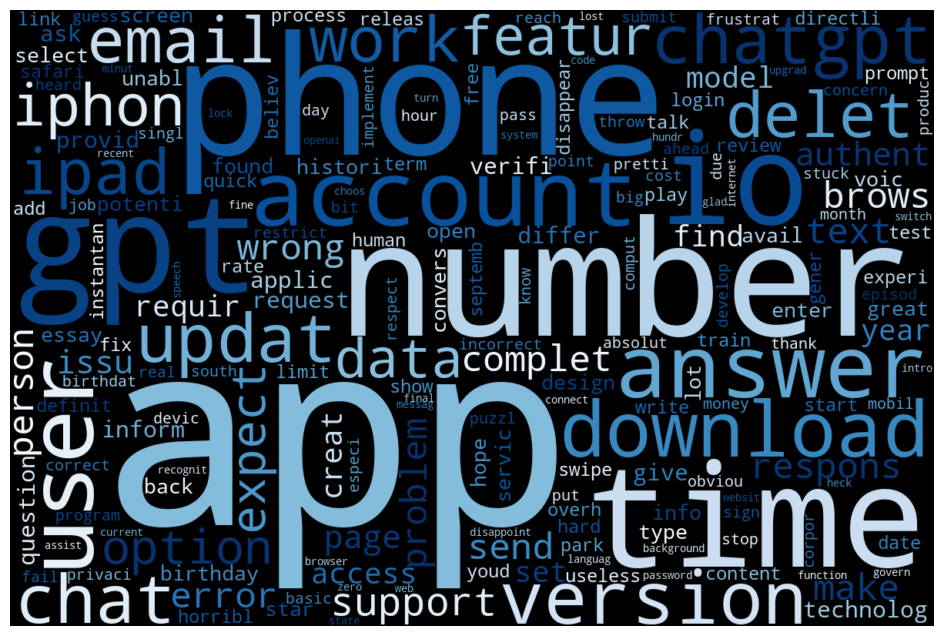

In [166]:
def show_wc(Word_cloud):
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(Word_cloud, interpolation="bilinear")
    plt.show()

all_words = "".join([str(doc).replace("'", "") for doc in labeled_data.review[labeled_data.labels == 1]])

word_cloud = WordCloud(
    width=1200,
    height=800,
    collocations=False,
    random_state=123,
    colormap="Blues_r"
).generate(all_words)

show_wc(word_cloud)

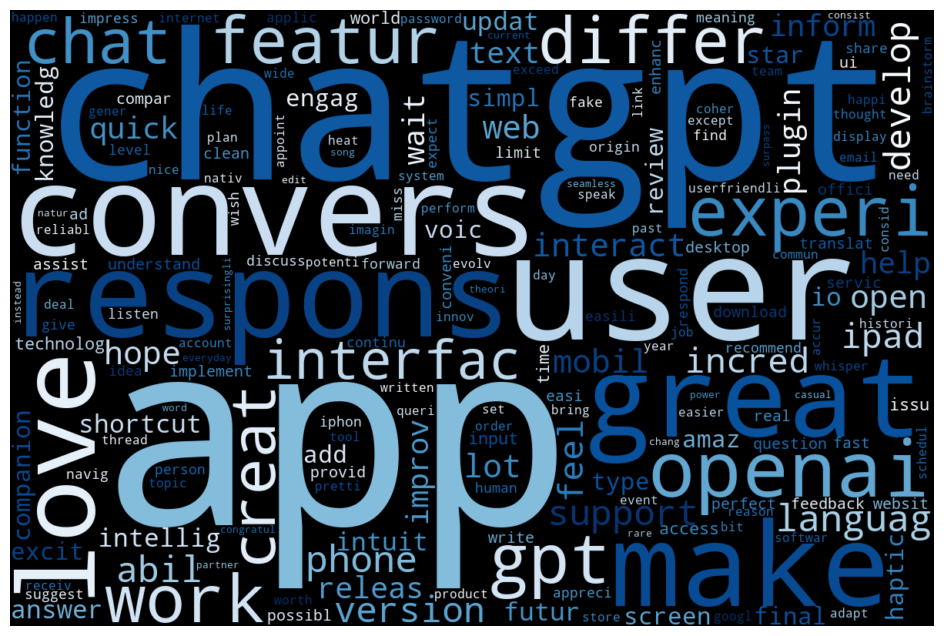

In [167]:
def show_wc(Word_cloud):
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(Word_cloud, interpolation="bilinear")
    plt.show()

all_words = "".join([str(doc).replace("'", "") for doc in labeled_data.review[labeled_data.labels == 5]])

word_cloud = WordCloud(
    width=1200,
    height=800,
    collocations=False,
    random_state=123,
    colormap="Blues_r"
).generate(all_words)

show_wc(word_cloud)

### **Document Frequency**

In [169]:
word_set = []

for doc in X_train:
    for word in doc:
        if word not in word_set:
            word_set.append(word)

n_documents = len(X_train)

index_dict = {}
for i, term in enumerate(word_set):
    index_dict[term] = i

index_dict

{'concern': 0,
 'privaci': 1,
 'delet': 2,
 'app': 3,
 'collect': 4,
 'info': 5,
 '’': 6,
 'add': 7,
 'finish': 8,
 'lyric': 9,
 'music': 10,
 'make': 11,
 'actual': 12,
 'song': 13,
 'creativ': 14,
 'real': 15,
 'instead': 16,
 'grow': 17,
 'level': 18,
 'love': 19,
 'show': 20,
 'replac': 21,
 'human': 22,
 'talk': 23,
 'cs': 24,
 'bill': 25,
 'bot': 26,
 'incorrect': 27,
 'mathemat': 28,
 'answer': 29,
 'math': 30,
 'confus': 31,
 'download': 32,
 'submit': 33,
 'email': 34,
 'phone': 35,
 'number': 36,
 'complet': 37,
 'puzzl': 38,
 'wrong': 39,
 'time': 40,
 'sit': 41,
 'watch': 42,
 'frustrat': 43,
 'databas': 44,
 'voip': 45,
 'googl': 46,
 'voic': 47,
 'compani': 48,
 'accumul': 49,
 'surveil': 50,
 'ipad': 51,
 'version': 52,
 'fit': 53,
 'screen': 54,
 'current': 55,
 '”': 56,
 'tini': 57,
 'window': 58,
 'perfect': 59,
 'edit': 60,
 'origin': 61,
 'star': 62,
 'chang': 63,
 'support': 64,
 'nice': 65,
 'work': 66,
 'happi': 67,
 'sign': 68,
 'pass': 69,
 'simplest': 70,
 'po

In [170]:
def document_frequency(docs):
    count_word = {}
    for term in word_set:
        count_word[term] = 0
        for doc in docs:
            if term in doc:
                count_word[term] += 1
    return count_word

count_word = document_frequency(X_train)
count_word


{'concern': 2,
 'privaci': 2,
 'delet': 8,
 'app': 107,
 'collect': 1,
 'info': 6,
 '’': 67,
 'add': 6,
 'finish': 2,
 'lyric': 1,
 'music': 1,
 'make': 21,
 'actual': 2,
 'song': 1,
 'creativ': 1,
 'real': 7,
 'instead': 2,
 'grow': 1,
 'level': 3,
 'love': 16,
 'show': 4,
 'replac': 1,
 'human': 7,
 'talk': 3,
 'cs': 1,
 'bill': 1,
 'bot': 2,
 'incorrect': 2,
 'mathemat': 1,
 'answer': 15,
 'math': 1,
 'confus': 1,
 'download': 13,
 'submit': 1,
 'email': 9,
 'phone': 26,
 'number': 13,
 'complet': 5,
 'puzzl': 1,
 'wrong': 8,
 'time': 16,
 'sit': 1,
 'watch': 1,
 'frustrat': 3,
 'databas': 1,
 'voip': 1,
 'googl': 4,
 'voic': 8,
 'compani': 2,
 'accumul': 1,
 'surveil': 1,
 'ipad': 12,
 'version': 17,
 'fit': 2,
 'screen': 10,
 'current': 4,
 '”': 7,
 'tini': 1,
 'window': 1,
 'perfect': 4,
 'edit': 3,
 'origin': 4,
 'star': 10,
 'chang': 4,
 'support': 14,
 'nice': 5,
 'work': 20,
 'happi': 3,
 'sign': 2,
 'pass': 2,
 'simplest': 1,
 'power': 3,
 'brain': 1,
 'underneath': 1,
 'ama

### **Term Frequency**

In [171]:
def term_frequency(doc, term):
    n_words = len(doc)
    occurate = doc.count(term)
    return occurate/n_words

### **Inverse Document Frequency**

In [172]:
def inverse_doc_fre(term):
    try:
        occurate = count_word[term] + 1
    except:
        occurate = 1
    return np.log(n_documents / occurate)

### **TF - IDF**

In [ ]:
def tf_idf_func(docs):
    

# **Modeling**

### **Create Class**

### **Training**

### **Testing**

### **Conclusion**